In [292]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import sys
import os
import pandas as pd
import spycon
import glob

import seaborn as sns

#https://github.com/christiando/spycon
#requires pip install git+https://github.com/christiando/spycon
#https://github.com/pwollstadt/IDTxl
#requires pip install git+https://github.com/pwollstadt/IDTxl
import spycon_utils

from typing import Tuple

from sklearn.cluster import DBSCAN

sys.path.append("..")
from analysis_package import maxlab_analysis as mla

import shutil

In [293]:
def get_filepath(div, well, method, remove_bursts = None): #In theory, can put in a parameter for all options, in order
    filepath = f"/run/user/1000/gvfs/smb-share:server=rstoreint.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/Experimental Data/nathan_senior_project_analysis/stim_removal_network_graphs_run_3/{method}/DIV{div}/well_no={well}/"
    if remove_bursts is not None:
        filepath += f"remove_bursts={remove_bursts}/"
    return filepath

In [294]:
all_networks = pd.DataFrame(columns = ["DIV", "Well number", "Inference method", "Burst removal", "filepath", "network"])


days = [33, 34, 35, 36, 37, 38]
methods = ["CoincidenceIndex", "Smoothed_CCG", "directed_STTC"]
for method in methods:
    for div in days:
        for well_no in range(6):
            for remove_bursts in [False, True]:
                filepath = get_filepath(div, well_no, method, remove_bursts)
                spycon_result = spycon.load_connectivity_result("spycon_network", filepath)
                all_networks.loc[len(all_networks.index), :] = [div, well_no, method, remove_bursts, filepath, spycon_result]

In [295]:
all_networks
all_networks["graph"] = all_networks["network"].apply(lambda i: i.create_nx_graph("weighted").to_undirected())
all_networks["Nodes"] = all_networks["graph"].apply(lambda i: i.order())
all_networks["Edges"] = all_networks["graph"].apply(lambda i: i.size())
all_networks["Average node degree"] = 2* all_networks["Edges"]/all_networks["Nodes"]
all_networks["Clustering coefficient"] = all_networks["graph"].apply(lambda i: nx.average_clustering(i))

def run_function(i, func):
    try:
        return func(i)
    except nx.NetworkXError:
        return np.nan

# def get_avg_shortest_path_length(i):
#     try:
#         return nx.average_shortest_path_length(i)
#     except nx.NetworkXError:
#         return np.nan

all_networks["Characteristic path length"] = all_networks["graph"].apply(lambda i: run_function(i, nx.average_shortest_path_length))
all_networks["Expected clustering coefficient (Erdos-Renyi)"] = all_networks["Edges"] / (0.5 * all_networks["Nodes"] * (all_networks["Nodes"] - 1))
#https://arxiv.org/abs/cond-mat/0407098
all_networks["Expected characteristic path length (Erdos-Renyi)"] = (np.log(all_networks["Nodes"]) - 0.57722)/np.log(all_networks["Average node degree"]) + 0.5

#https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.smallworld.sigma.html#networkx.algorithms.smallworld.sigma
all_networks["Small-world coefficient"] = (all_networks["Clustering coefficient"]/all_networks["Expected clustering coefficient (Erdos-Renyi)"])/(all_networks["Characteristic path length"]/(all_networks["Expected characteristic path length (Erdos-Renyi)"]))

all_networks

,DIV,Well number,Inference method,Burst removal,filepath,network,graph,Nodes,Edges,Average node degree,Clustering coefficient,Characteristic path length,Expected clustering coefficient (Erdos-Renyi),Expected characteristic path length (Erdos-Renyi),Small-world coefficient
0,33,0,CoincidenceIndex,False,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",47,1033,43.957447,0.959153,1.044403,0.955597,1.365116,1.311942
1,33,0,CoincidenceIndex,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",71,360,10.140845,0.583121,1.920724,0.144869,2.090911,4.381808
2,33,1,CoincidenceIndex,False,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",50,1178,47.120000,0.967435,1.038367,0.961633,1.365576,1.323053
3,33,1,CoincidenceIndex,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",65,457,14.061538,0.461570,1.824038,0.219712,1.860789,2.143128
4,33,2,CoincidenceIndex,False,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",48,1073,44.708333,0.960097,1.048759,0.951241,1.366801,1.315388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,38,3,directed_STTC,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",46,933,40.565217,0.928248,1.098551,0.901449,1.378072,1.291738
212,38,4,directed_STTC,False,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",36,591,32.833333,0.945611,1.061905,0.938095,1.361047,1.291973
213,38,4,directed_STTC,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",38,510,26.842105,0.886619,NaN,0.725462,1.430210,NaN
214,38,5,directed_STTC,False,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7)",8,24,6.000000,0.841071,1.142857,0.857143,1.338406,1.149147


Burst removal
False    108
True     108
Name: Nodes, dtype: int64


/tmp/ipykernel_3563520/2379264955.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(xposlist[j], ax.get_ylim()[1], f"n={counts[j]/3}", horizontalalignment = "center")


(-28.84250883838403, 141.12376208515033)

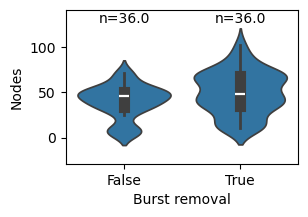

In [296]:
plt.figure(figsize = [3, 2])
sns.violinplot(data=all_networks, x = "Burst removal", y="Nodes", inner = "box", density_norm= "count", common_norm= True, inner_kws=dict(box_width=8, whis_width=2))
#sns.stripplot(data=all_networks, x = "Burst removal", y="nodes")

#sns.swarmplot(data=all_networks, x = "Burst removal", y="nodes", palette='deep', dodge = True, hue = "Burst removal", )

all_cols = all_networks.groupby(["Burst removal"])["Nodes"]
print(all_cols.count())
counts = all_cols.count()
yposlist = all_cols.max().tolist()
xposlist = [0, 1]

ax = plt.gca()
for j in range(len(xposlist)):
    ax.text(xposlist[j], ax.get_ylim()[1], f"n={counts[j]/3}", horizontalalignment = "center")

ylim_range = ax.get_ylim()[1] - ax.get_ylim()[0]
ax.set_ylim([ax.get_ylim()[0] - ylim_range * 0.1, ax.get_ylim()[1] + ylim_range * 0.1])



Burst removal
False    108
True     108
Name: Nodes, dtype: int64


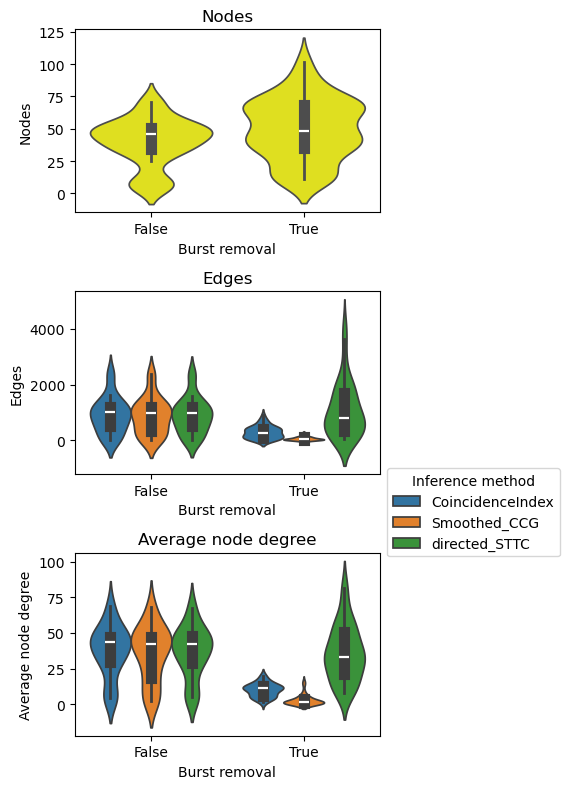

In [309]:
#plt.scatter(all_networks["DIV"], all_networks["average_degree"], label = np.array(all_networks["Inference method"]))
y_value_columns = all_networks.columns[8:10]
plt.figure(figsize = (4, 8))

plt.subplot(3, 1, 1)
plt.title("Nodes")
sns.violinplot(data=all_networks, x = "Burst removal", y="Nodes", inner = "box", density_norm= "count", common_norm= True, inner_kws=dict(box_width=8, whis_width=2), color="yellow")
#sns.stripplot(data=all_networks, x = "Burst removal", y="nodes")

#sns.swarmplot(data=all_networks, x = "Burst removal", y="nodes", palette='deep', dodge = True, hue = "Burst removal", )

all_cols = all_networks.groupby(["Burst removal"])["Nodes"]
print(all_cols.count())
counts = all_cols.count()
yposlist = all_cols.max().tolist()
xposlist = [0, 1]

ax = plt.gca()





for i, y_val_col in enumerate(y_value_columns):
    ax = plt.subplot(3, 1, i+2) 

    plt.title(y_val_col)
    all_cols = all_networks.groupby(["Burst removal", "Inference method"])[y_val_col]
    counts = all_cols.count()
    yposlist = all_cols.max().tolist()
    dist = 0.27
    xposlist = [ 0- dist, 0, 0 + dist, 1-dist, 1, 1+dist]
   
    if i == 1:
        sns.violinplot(data=all_networks, x = "Burst removal", y=y_val_col, dodge = True, hue = "Inference method", density_norm = "count", common_norm= True, legend = True,  inner_kws=dict(box_width=8, whis_width=2))

    else:
        sns.violinplot(data=all_networks, x = "Burst removal", y=y_val_col, dodge = True, hue = "Inference method", density_norm = "count", common_norm= True, legend = False,  inner_kws=dict(box_width=8, whis_width=2))


plt.tight_layout()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.50))
#plt.legend()


In [299]:
all_networks

all_networks["Type"] = "Inferred"
index = all_networks.index
for i in index:
    all_networks.loc[len(all_networks.index), ["Burst removal", "Inference method", "Clustering coefficient", "Type"]] = list(all_networks.loc[i, ["Burst removal", "Inference method", "Expected clustering coefficient (Erdos-Renyi)"]]) + ["Random"]

all_networks

,DIV,Well number,Inference method,Burst removal,filepath,network,graph,Nodes,Edges,Average node degree,Clustering coefficient,Characteristic path length,Expected clustering coefficient (Erdos-Renyi),Expected characteristic path length (Erdos-Renyi),Small-world coefficient,Type
0,33,0,CoincidenceIndex,False,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",47.0,1033.0,43.957447,0.959153,1.044403,0.955597,1.365116,1.311942,Inferred
1,33,0,CoincidenceIndex,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",71.0,360.0,10.140845,0.583121,1.920724,0.144869,2.090911,4.381808,Inferred
2,33,1,CoincidenceIndex,False,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",50.0,1178.0,47.120000,0.967435,1.038367,0.961633,1.365576,1.323053,Inferred
3,33,1,CoincidenceIndex,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",65.0,457.0,14.061538,0.461570,1.824038,0.219712,1.860789,2.143128,Inferred
4,33,2,CoincidenceIndex,False,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",48.0,1073.0,44.708333,0.960097,1.048759,0.951241,1.366801,1.315388,Inferred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,NaN,NaN,directed_STTC,True,NaN,NaN,NaN,NaN,NaN,NaN,0.901449,NaN,NaN,NaN,NaN,Random
428,NaN,NaN,directed_STTC,False,NaN,NaN,NaN,NaN,NaN,NaN,0.938095,NaN,NaN,NaN,NaN,Random
429,NaN,NaN,directed_STTC,True,NaN,NaN,NaN,NaN,NaN,NaN,0.725462,NaN,NaN,NaN,NaN,Random
430,NaN,NaN,directed_STTC,False,NaN,NaN,NaN,NaN,NaN,NaN,0.857143,NaN,NaN,NaN,NaN,Random


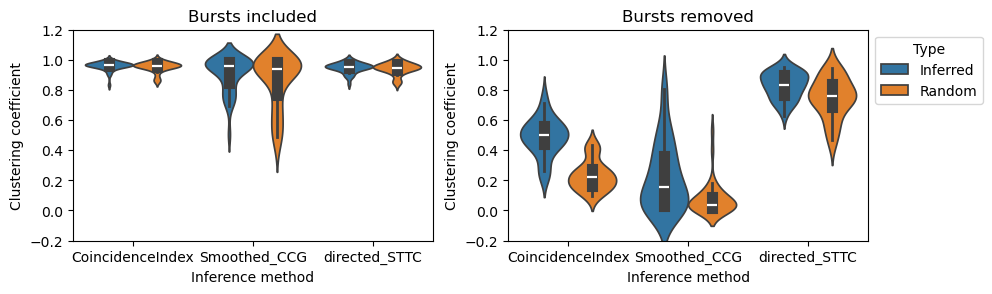

In [312]:
#plt.scatter(all_networks["DIV"], all_networks["average_degree"], label = np.array(all_networks["Inference method"]))
y_value_columns = all_networks.columns[10:14:2]
plt.figure(figsize = (10, 8))

all_networks_bursts_included = all_networks.loc[all_networks["Burst removal"] == False]
all_networks_bursts_removed = all_networks.loc[all_networks["Burst removal"] == True]
titles = ["Bursts included", "Bursts removed"]
for i, networks in enumerate([all_networks_bursts_included, all_networks_bursts_removed]):
    ax = plt.subplot(3, 2, i+1) 

    plt.title(titles[i])
   
    if i == 1:
        sns.violinplot(data=networks, x = "Inference method", y="Clustering coefficient", dodge = True, hue = "Type", density_norm = "count", common_norm= True, legend = True,  inner_kws=dict(box_width=8, whis_width=2))
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        sns.violinplot(data=networks, x = "Inference method", y="Clustering coefficient", dodge = True, hue = "Type", density_norm = "count", common_norm= True, legend = False,  inner_kws=dict(box_width=8, whis_width=2))

    plt.ylim([-0.2, 1.2])
plt.tight_layout()

Burst removal  Inference method
True           CoincidenceIndex    36
               Smoothed_CCG        36
Name: Edges, dtype: int64
Burst removal  Inference method
True           CoincidenceIndex    36
               Smoothed_CCG        36
Name: Average node degree, dtype: int64


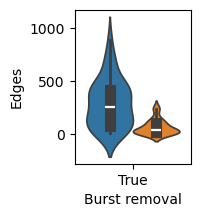

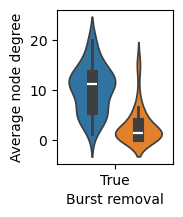

In [260]:
no_directed = all_networks.loc[(all_networks["Inference method"] != 'directed_STTC' )& (all_networks["Burst removal"] == True)]
y_value_columns = no_directed.columns[8:10]

for i, y_val_col in enumerate(y_value_columns):
    plt.figure(figsize = (1.5,2))
    ax = plt.gca()

    all_cols = no_directed.groupby(['Burst removal', 'Inference method'])[y_val_col]
    print(all_cols.count())
    counts = all_cols.count()
    yposlist = all_cols.max().tolist()
    dist = 0.19
    xposlist = [ 0- dist, 0 + dist]
   
    sns.violinplot(data=no_directed, x = "Burst removal", y=y_val_col, dodge = True, hue = "Inference method", density_norm = "count", common_norm= True, legend = False,  inner_kws=dict(box_width=8, whis_width=2))



#plt.tight_layout()

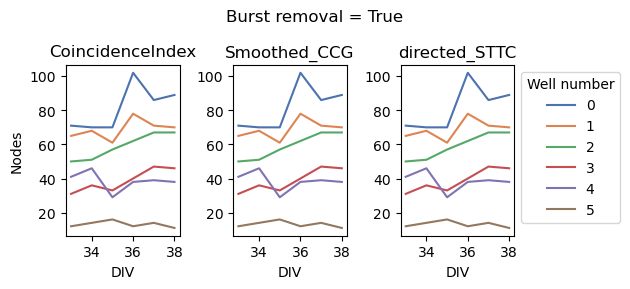

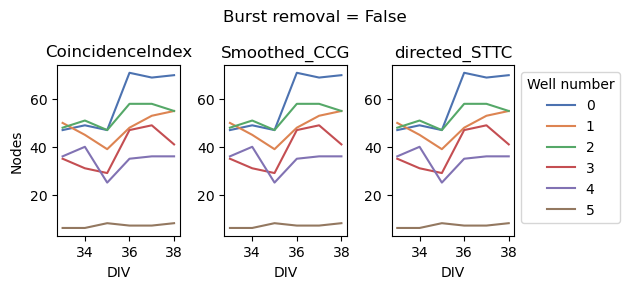

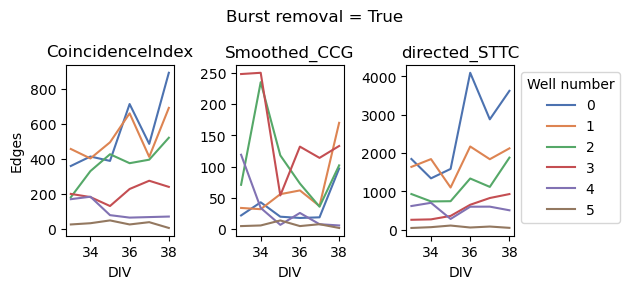

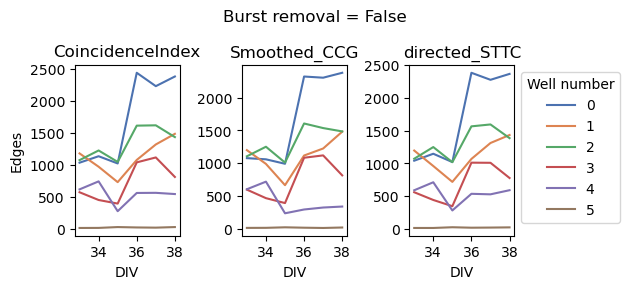

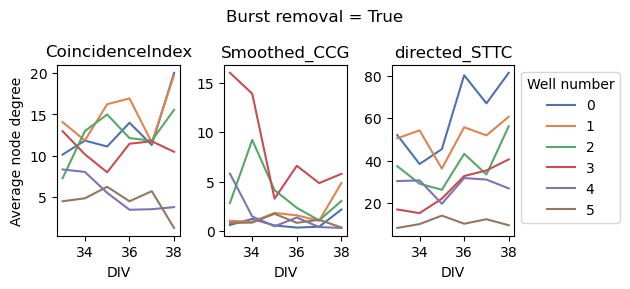

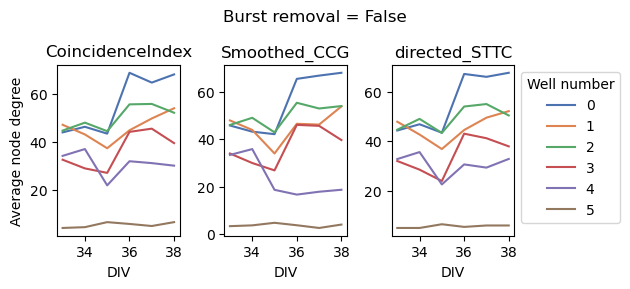

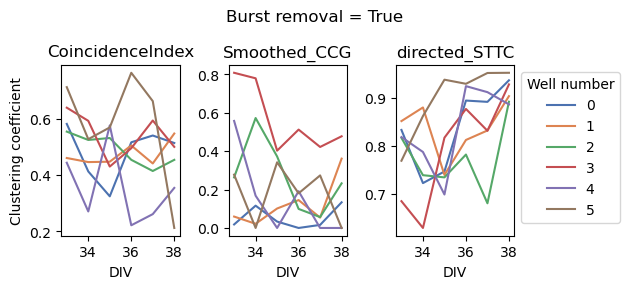

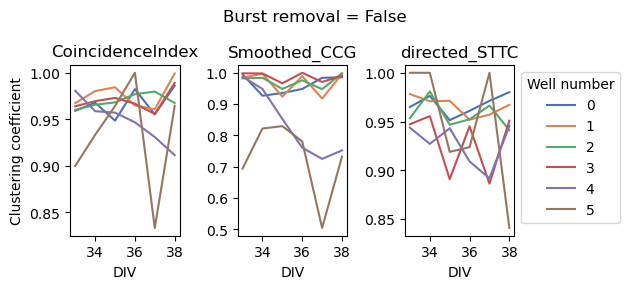

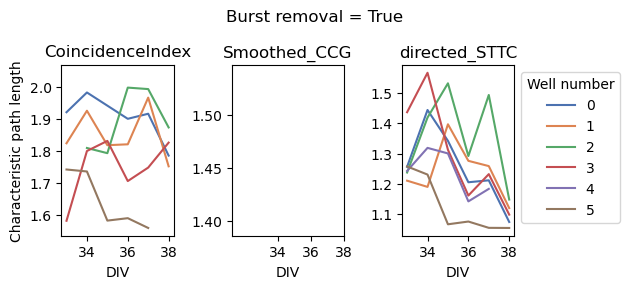

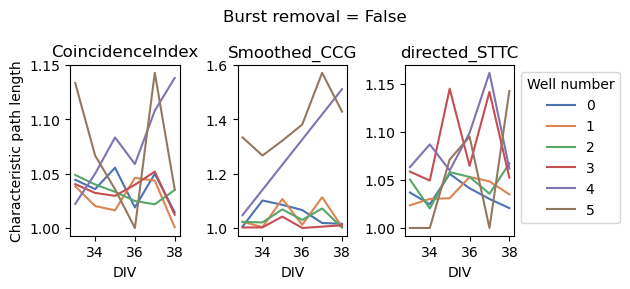

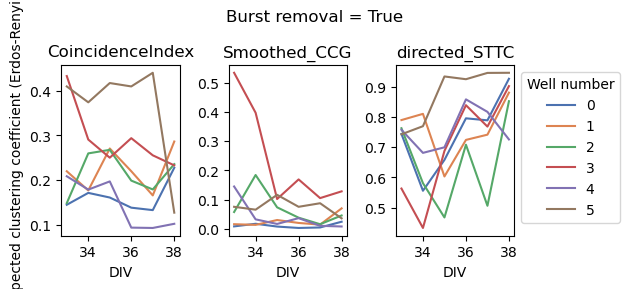

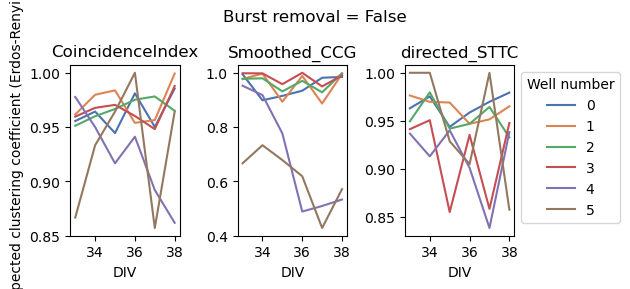

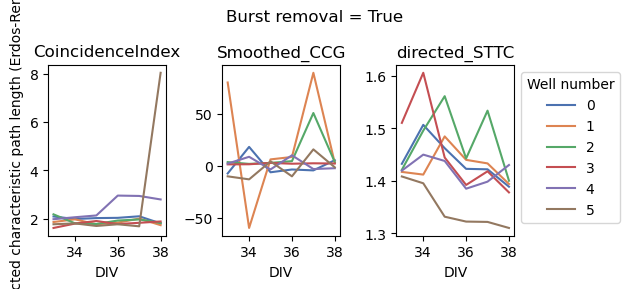

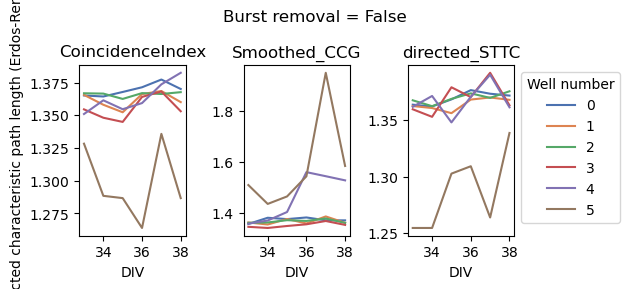

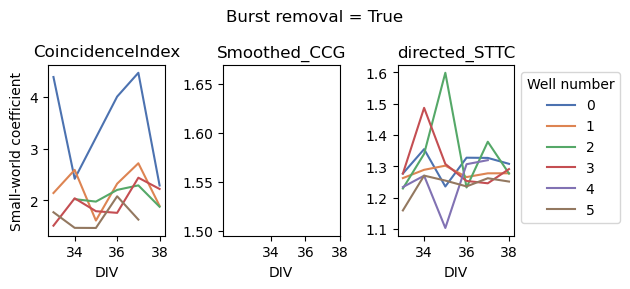

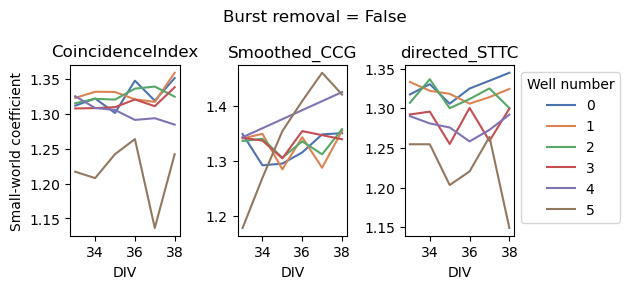

In [241]:
y_value_columns = all_networks.columns[7:16]

for y_val_col in y_value_columns:
    plt.figure()
    plt.suptitle("Burst removal = True")
    for i, method in enumerate(all_networks["Inference method"].unique()):
        all_networks_by_method = all_networks.loc[all_networks["Inference method"] == method]
        plt.subplot(2, 3, i+1)
        ax = plt.gca()
        plt.title(method)
        if i == 2:
            sns.lineplot(data=all_networks_by_method.loc[all_networks_by_method["Burst removal"] == True], x='DIV', y= y_val_col, hue='Well number', palette="deep", legend = True)
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        else:
            sns.lineplot(data=all_networks_by_method.loc[all_networks_by_method["Burst removal"] == True], x='DIV', y=y_val_col, hue='Well number', palette="deep", legend = False)

        if i != 0:
            ax.set(ylabel=None)
        ax.set(xticks = [34, 36,38])

    plt.tight_layout()

    plt.figure()
    plt.suptitle("Burst removal = False")
    for i, method in enumerate(all_networks["Inference method"].unique()):
        all_networks_by_method = all_networks.loc[all_networks["Inference method"] == method]
        plt.subplot(2, 3, i+1)
        ax = plt.gca()
        plt.title(method)
        if i == 2:
            sns.lineplot(data=all_networks_by_method.loc[all_networks_by_method["Burst removal"] == False], x='DIV', y=y_val_col, hue='Well number', palette="deep", legend = True)
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        else:
            sns.lineplot(data=all_networks_by_method.loc[all_networks_by_method["Burst removal"] == False], x='DIV', y=y_val_col, hue='Well number', palette="deep", legend = False)
        
        if i != 0:
            ax.set(ylabel=None)

        ax.set(xticks = [34, 36,38])

    plt.tight_layout()

In [66]:
selected_networks = all_networks.loc[(all_networks["DIV"] == 33) & (all_networks["well"] == 3) & (all_networks["Burst removal"] == True), :]
selected_networks


,DIV,well,method,remove_bursts,filepath,network,graph,nodes,edges,average_degree,average_clustering,average_shortest_path_length
7,33,3,CoincidenceIndex,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",31,312,10.064516,0.526679,1.775269
79,33,3,Smoothed_CCG,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",31,390,12.580645,0.787549,1.611828
151,33,3,directed_STTC,True,/run/user/1000/gvfs/smb-share:server=rstoreint...,<spycon.spycon_result.SpikeConnectivityResult ...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",31,342,11.032258,0.491857,NaN


/home/mxwbio/miniconda3/envs/nathan_senior_project/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(
/home/mxwbio/miniconda3/envs/nathan_senior_project/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(
/home/mxwbio/miniconda3/envs/nathan_senior_project/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


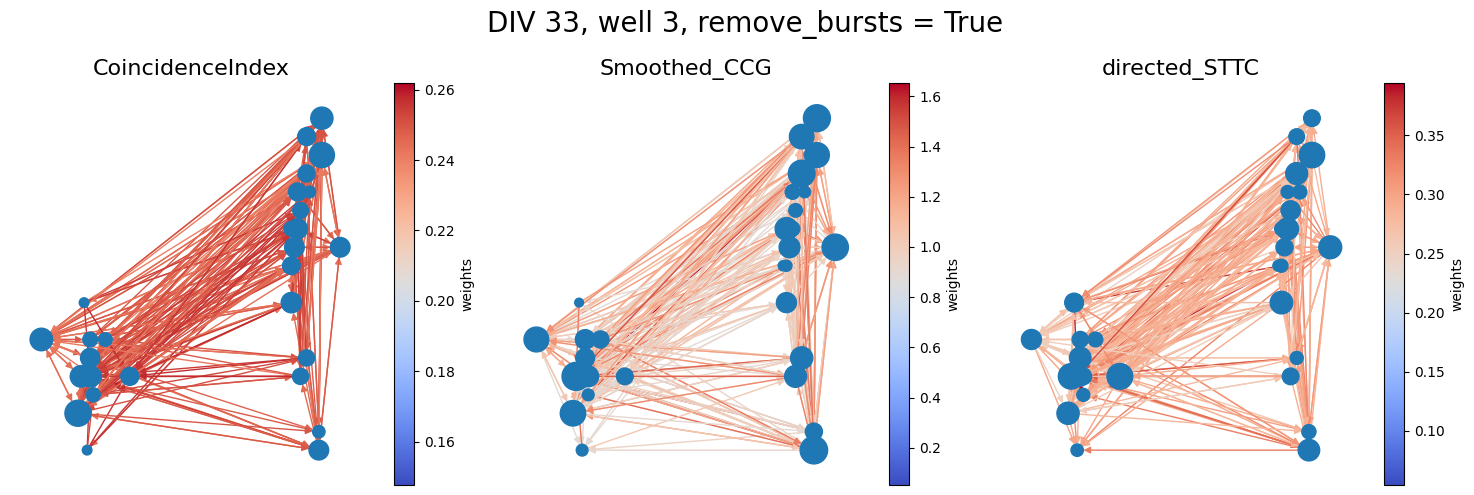

In [68]:
plt.figure(figsize = (15, 5))
plt.suptitle(f"DIV 33, well 3, remove_bursts = True", fontsize = 20)
for i, index in enumerate(selected_networks.index):
    plt.subplot(1, len(selected_networks), i + 1)
    plt.title(selected_networks.loc[index, "Inference method"], fontsize = 16)
    filepath = selected_networks.loc[index, "filepath"]
    grouped_mapping_df = pd.read_csv(filepath + "08_grouped_mapping_df.csv")


    graph = selected_networks.loc[index, "graph"]

    degrees = graph.degree() #ict with Node ID, Degree
    nodes = graph.nodes()
    n_color = np.asarray([degrees[n] for n in nodes])


    pos = nx.circular_layout(graph)
    for i in grouped_mapping_df.index:
        pos[i] = np.array(grouped_mapping_df.loc[i, ["x", "y"]] )

    cmap = plt.get_cmap("coolwarm")
    weights = list(nx.get_edge_attributes(graph, "weight").values())
    min_weight = np.amin(np.absolute(weights))
    max_weight = np.amax(np.absolute(weights))
    norm = mpl.colors.Normalize(vmin=min_weight, vmax=max_weight)
    nx.draw(graph, pos, with_labels=False,
            
            node_size = n_color * 8,
            cmap = "viridis",
            vmin = 0,
            vmax = 50,
            edge_color=weights,
            edge_vmin=-max_weight,
            edge_vmax=max_weight,
            edge_cmap=cmap,
            )
    plt.colorbar(
                mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax = plt.gca(), 
                label="weights",
        )
    #nx.draw(graph, pos, with_labels=True)
    
plt.tight_layout()

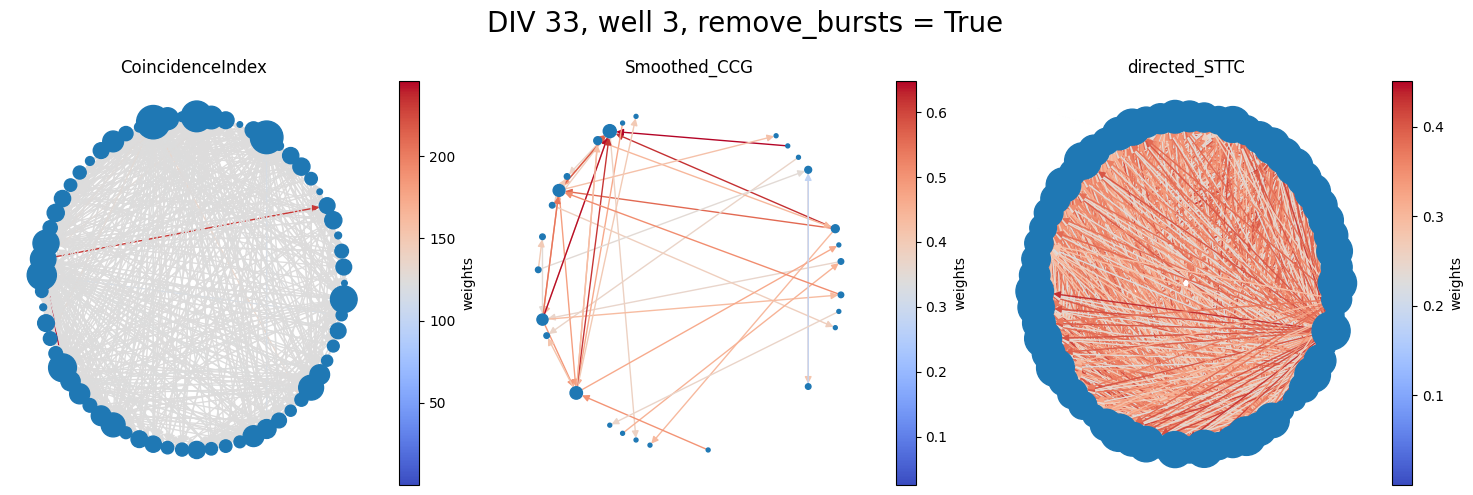

In [62]:
plt.figure(figsize = (15, 5))
plt.suptitle(f"DIV 33, well 3, remove_bursts = True", fontsize = 20)
for i, index in enumerate(selected_networks.index):
    plt.subplot(1, len(selected_networks), i + 1)
    plt.title(selected_networks.loc[index, "Inference method"])
    filepath = selected_networks.loc[index, "filepath"]
    grouped_mapping_df = pd.read_csv(filepath + "08_grouped_mapping_df.csv")


    graph = selected_networks.loc[index, "graph"]

    degrees = graph.degree() #ict with Node ID, Degree
    nodes = graph.nodes()
    n_color = np.asarray([degrees[n] for n in nodes])
    
    if i == 0:
        pos = nx.nx_agraph.graphviz_layout(graph, prog = "sfdp")
        pos = nx.circular_layout(graph)
    
    cmap = plt.get_cmap("coolwarm")
    weights = list(nx.get_edge_attributes(graph, "weight").values())
    min_weight = np.amin(np.absolute(weights))
    max_weight = np.amax(np.absolute(weights))
    norm = mpl.colors.Normalize(vmin=min_weight, vmax=max_weight)
    nx.draw(graph, pos, with_labels=False,
            
            node_size = n_color * 8,
            
            edge_color=weights,
            edge_vmin=-max_weight,
            edge_vmax=max_weight,
            edge_cmap=cmap,
            )
    plt.colorbar(
                mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax = plt.gca(), 
                label="weights",
        )
    #nx.draw(graph, pos, with_labels=True)
    
plt.tight_layout()

In [12]:
filepath = get_filepath(33, 0, "CoincidenceIndex", remove_bursts = True)
spycon_result = spycon.load_connectivity_result("spycon_network", filepath)
grouped_mapping_df = pd.read_csv(filepath + "08_grouped_mapping_df.csv")

In [26]:
print(len(spycon_result.edges))
graph = spycon_result.create_nx_graph()
print(graph.size())



84
84


In [5]:
grouped_mapping_df

,channel,electrode,x,y,frequency,mean amp
0,0,9051,542.5,717.5,1.400012,0.589144
1,1,11849,3307.5,927.5,1.600014,1.878607
2,2,13437,297.5,1067.5,14.300128,3.085710
3,3,12291,3342.5,962.5,1.100010,0.751733
4,4,12997,297.5,1032.5,2.800025,0.562933
...,...,...,...,...,...,...
616,1015,21917,2397.5,1732.5,2.400021,1.100242
617,1019,22359,2432.5,1767.5,1.750016,1.718806
618,1021,12687,2572.5,997.5,3.500031,0.712002
619,1022,21871,1592.5,1732.5,0.200002,4.086903


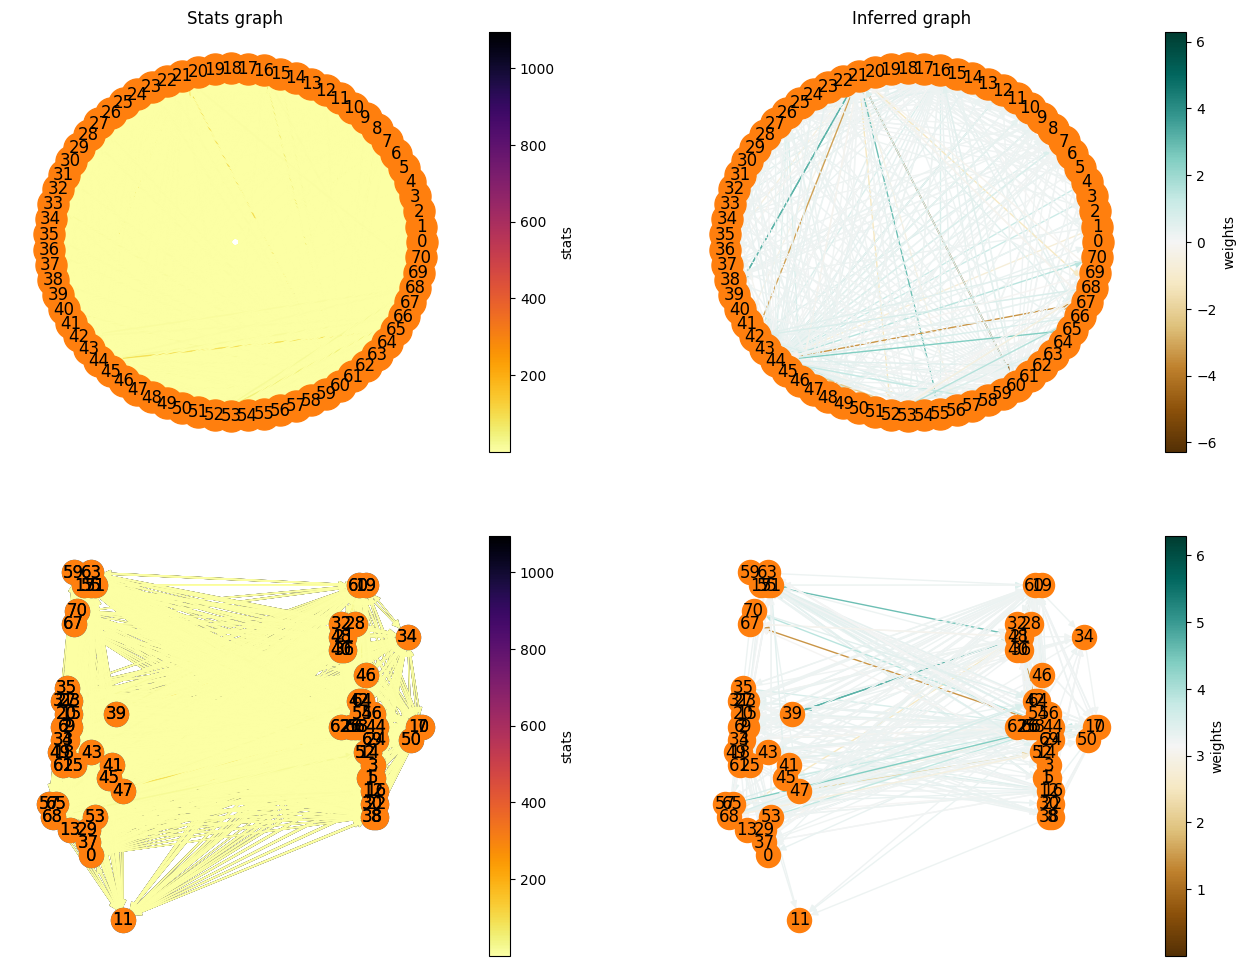

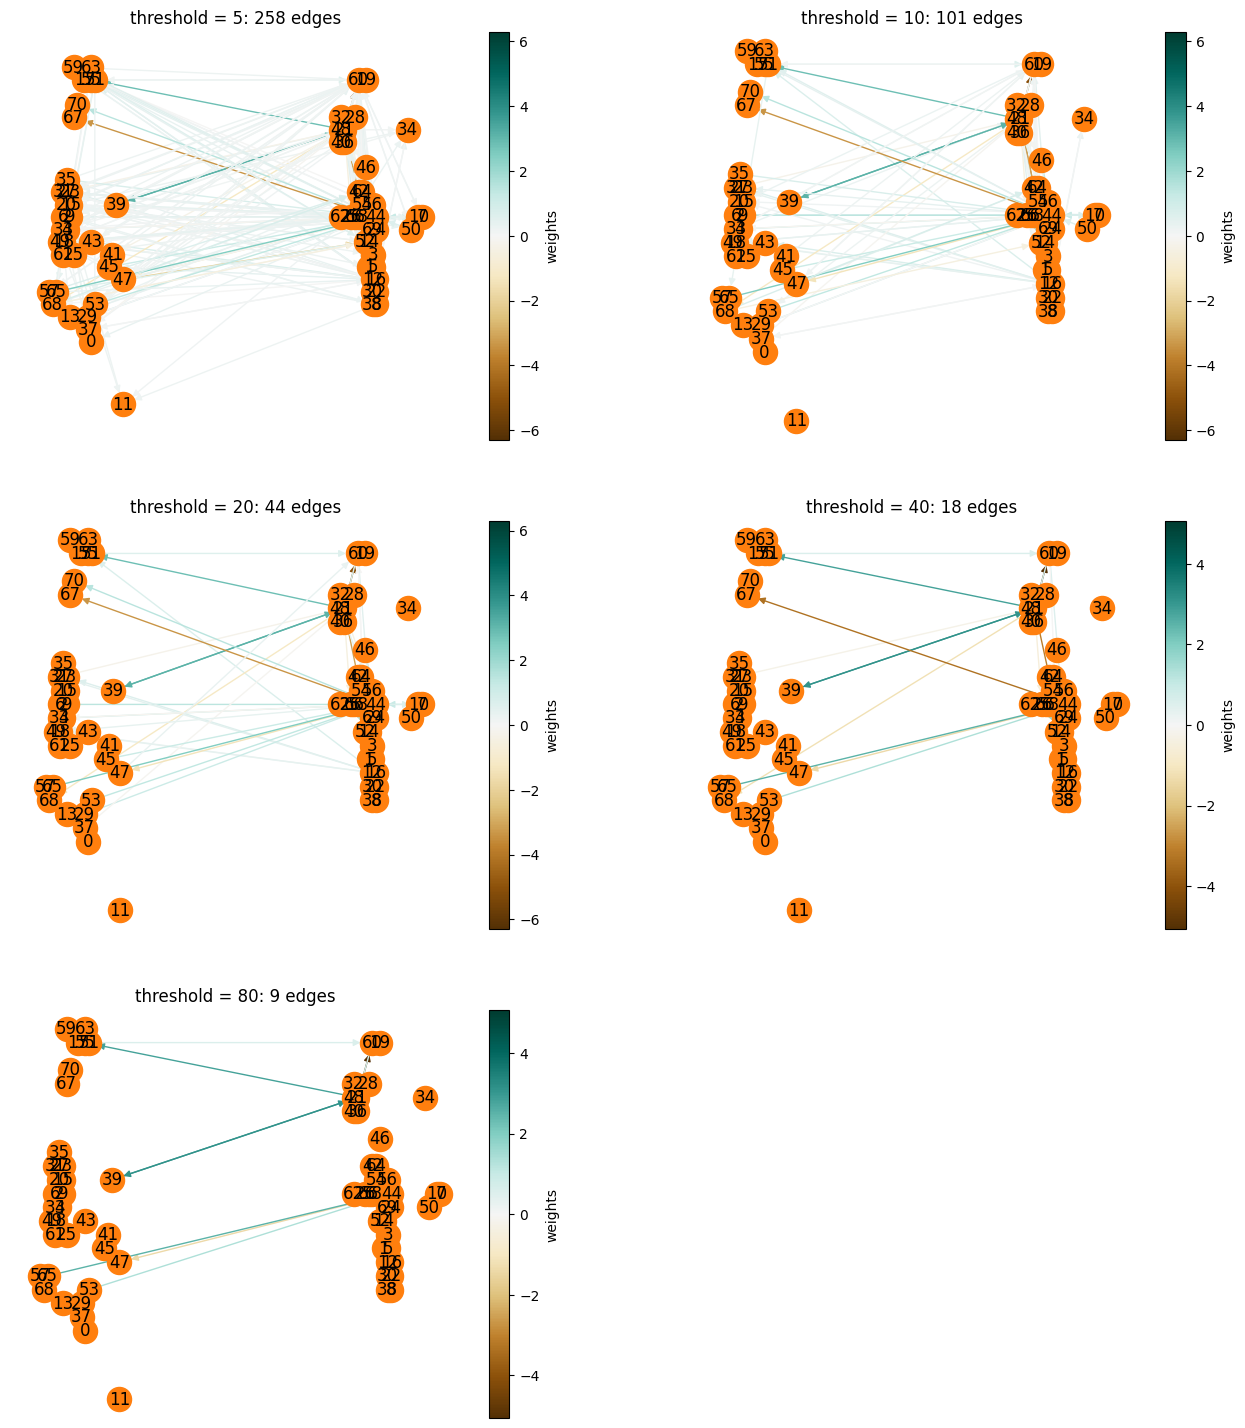

In [6]:

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
g1 = spycon_result.draw_graph(graph_type='stats', ax=ax1)
pos1 = nx.circular_layout(g1)
for i in grouped_mapping_df.index:
    pos1[i] = np.array(grouped_mapping_df.loc[i, ["x", "y"]] )

ax1.set_title('Stats graph')
ax2 = fig.add_subplot(222)
g2 = spycon_result.draw_graph(graph_type='weighted', ax=ax2)
pos2 = nx.circular_layout(g2)
for i in grouped_mapping_df.index:
    pos2[i] = np.array(grouped_mapping_df.loc[i, ["x", "y"]])
ax2.set_title('Inferred graph')

ax3=fig.add_subplot(223)
nx.draw(g1, pos1, with_labels=True)
cmap = plt.get_cmap("inferno_r")
weights = list(nx.get_edge_attributes(g1, "weight").values())
min_weight, max_weight = np.amin(weights), np.amax(weights)
norm = mpl.colors.Normalize(vmin=min_weight, vmax=max_weight)
nx.draw(g1, pos1, with_labels=True,
        node_color="C1",
        edge_color=weights,
        edge_vmin=min_weight,
        edge_vmax=max_weight,
        edge_cmap=cmap,
        )
plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax = plt.gca(), 
            label="stats",
        )

ax4=fig.add_subplot(224)
cmap = plt.get_cmap("BrBG")
weights = list(nx.get_edge_attributes(g2, "weight").values())
max_weight = np.amax(np.absolute(weights))
norm = mpl.colors.Normalize(vmin=min_weight, vmax=max_weight)
nx.draw(g2, pos2, with_labels=True,
        node_color="C1",
        edge_color=weights,
        edge_vmin=-max_weight,
        edge_vmax=max_weight,
        edge_cmap=cmap,
        )
plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax = plt.gca(), 
            label="weights",
        )
plt.show()




fig = plt.figure(figsize=(16,18))
for num, thresh in enumerate([5, 10, 20, 40, 80]):
    spycon_result.set_threshold(thresh)
    ax = plt.subplot(3, 2, num+1)
    
    try:
        g = spycon_utils.draw_graph_with_mapping(spycon_result, grouped_mapping_df, "weighted", ax = ax)
    except Exception as err:
        print(err)
    plt.title("threshold = " + str(thresh) + ": " + str(len(g.edges)) + " edges")
plt.show()
